# Projeto da III Unidade de PI Contagem de hemácias

### Alunos

- Gabriel Silva de Jesus
- Gustavo Henrique Aragão Silva

---

In [73]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

Leitura de uma imagem para descobrir detalhes iniciais:

In [74]:
nome_image = 'BloodImage_00402.jpg'

image_color = io.imread(nome_image)


----
### Passo 1 - Extrair  os leucócitos para explorar somente hemácias

1.1 Com a sugestão do professor exploramos os canais HSV e olhamos mais especificamente para o canal H que define a cor. Assim conseguiremos remover os leucócitos. Para isso procuramos os valores maximos existentes de H numa dada imagem.


In [75]:
hsv = cv2.cvtColor(image_color, cv2.COLOR_BGR2HSV)

h, s, v = cv2.split(hsv)

# Encontrar o valor máximo de HSV
max_h, max_s, max_v = np.max(h), np.max(s), np.max(v)

print("Valor máximo de H S V respectivamente:", max_h, max_s, max_v)

Valor máximo de H S V respectivamente: 179 171 246


1.2 Após encontrar os valores máximos foi feita a variacao do canal H e encontramos o intervalo de H (160 a 180) em que  leucócito está. Após encontrado  o leucocito  obtemos o conjuto complementar que é o conjunto que só existem hemácias.

```
lower = np.array([160, 0, 0])
upper = np.array([180, 161, 247])
```

veja que adicionamos 1 a mais em cada item só por segurança, mas isso não faz diferença na nossa implementação

-  1.2.0 A função abaixo cria uma mascara dado intevalos inferiores e superiores 

In [76]:
def manual_inRange(hsv, lower, upper):

    h, s, v = hsv[:,:,0], hsv[:,:,1], hsv[:,:,2]
    
    h_mask = np.logical_and(h >= lower[0], h <= upper[0])
    s_mask = np.logical_and(s >= lower[1], s <= upper[1])
    v_mask = np.logical_and(v >= lower[2], v <= upper[2])
    
    return (h_mask & s_mask & v_mask).astype(np.uint8) * 255

- 1.2.1 A função abaixo faz a operação de bitwise and entre duas imagens tendo a uma máscara fornecida como base, se o parâmetro negacao=True quer dizer que estaremos aplicando a operação de not na máscara para que a imagem a ser obtida seja complementar do intervalo h inicialmente selecionado.

In [77]:
def manual_bitwise_and(img1, img2, mask, negacao=False):
    if img1.shape[:2] != img2.shape[:2] or img1.shape[:2] != mask.shape[:2]:
        raise ValueError("I tamaho das imagens e da mascara deve ser iguais.")
    
    h, w, _ = img1.shape

    result_img = np.zeros((h, w, _), dtype=np.uint8)
    
    for i in range(h):
        for j in range(w):
            # pega o complementar da imagem ou não a partir da mascara
            mask_tratada = ~mask[i, j] if negacao else mask[i, j]  
            result_img[i, j] = img1[i, j] & img2[i, j] & mask_tratada # Aplica o bitwise
    
    return result_img

- 1.2.2 Por fim,  função abaixo identifica e remove os leucócitos da imagemn dada, deixando somente as hemácias que é a parte que queremos :)

In [78]:
def RemoveGlobulosBrancos(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Intervalo que se encontram os globulos brancos
    lower = np.array([160, 0, 0]) 
    upper = np.array([180, 161, 247])

    mask = manual_inRange(hsv, lower, upper) # obtém a mascara com o interva

    # Faz a limpeza de ruidos que ficam na imagem. Aplicando o fechamento e após a abertura
    b = np.ones((12,12),np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, b)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, b)
   
    return manual_bitwise_and(img, img, mask=mask, negacao=True) 


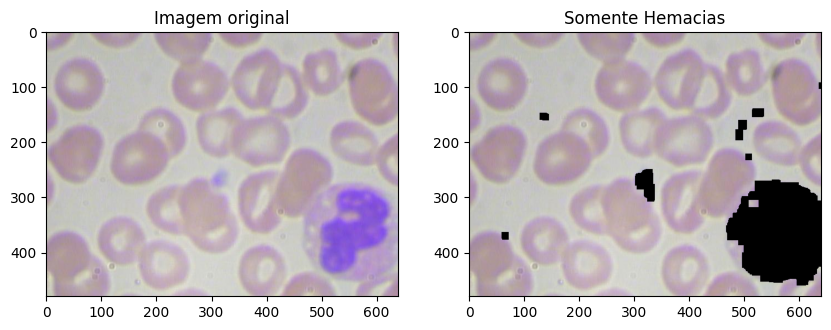

In [79]:
# testando
h = RemoveGlobulosBrancos(image_color)

def plotarTeste(img1, msg1, img2, msg2):
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,8))
  fig.subplots_adjust(hspace= .2, wspace= .2)

  ax[0].imshow(img1)
  ax[0].set_title(msg1)

  ax[1].imshow(img2)
  ax[1].set_title(msg2)

plotarTeste(image_color, 'Imagem original', h, 'Somente Hemacias')

----

### Passo 2 - Pré-processamento, tratamento e limiarização das imagens.


A função meu_adaptiveThreshold implementa um algoritmo de limiarização adaptativa em imagens em tons de cinza. Ela calcula limiares localmente com base na média ou no desvio padrão dos valores de intensidade em regiões específicas da imagem. Dependendo do método escolhido, o limiar é ajustado pela média ou pela média e desvio padrão. 

No nosso projeto testamos tanto a média quanto o desvio padrão e com base  nos testes selecionamos a opção da média pois foi ela que nos deu a melhor acurácia.

In [80]:
def meu_adaptiveThreshold(img, max_level, metodo, type_threshold, block_size, C):
    
    tamanho_borda = block_size // 2

    # Adiciona borda à imagem de entrada
    borda_img = np.pad(img, tamanho_borda, mode='constant')

    # Inicializa a imagem de saída
    img_saida = np.zeros_like(img)

    j, i = img.shape
    for y in range(tamanho_borda, j + tamanho_borda):
        for x in range(tamanho_borda, i + tamanho_borda):
            roi = borda_img[y - tamanho_borda:y + tamanho_borda + 1, x - tamanho_borda:x + tamanho_borda + 1]
            
            # Aplica o threshold da media
            if metodo == 0:
                threshold_value = np.mean(roi) - C
            # aplica o threshold gaussiano
            else:
                threshold_value = np.mean(roi) - C * np.std(roi) / block_size
            
            # aplica o threshold gaussiano
            if type_threshold == 0:
                img_saida[y - tamanho_borda, x - tamanho_borda] = max_level if img[y - tamanho_borda, x - tamanho_borda] > threshold_value else 0
            
            # aplica o threshold da  media
            else:
                img_saida[y - tamanho_borda, x - tamanho_borda] = 0 if img[y - tamanho_borda, x - tamanho_borda] > threshold_value else max_level



